In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# SPECTER
from spectral_emd import compute_spectral_representation, cumulative_spectral_function
from spectral_emd import ds2


# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event




# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


Max # of particles: 111
test


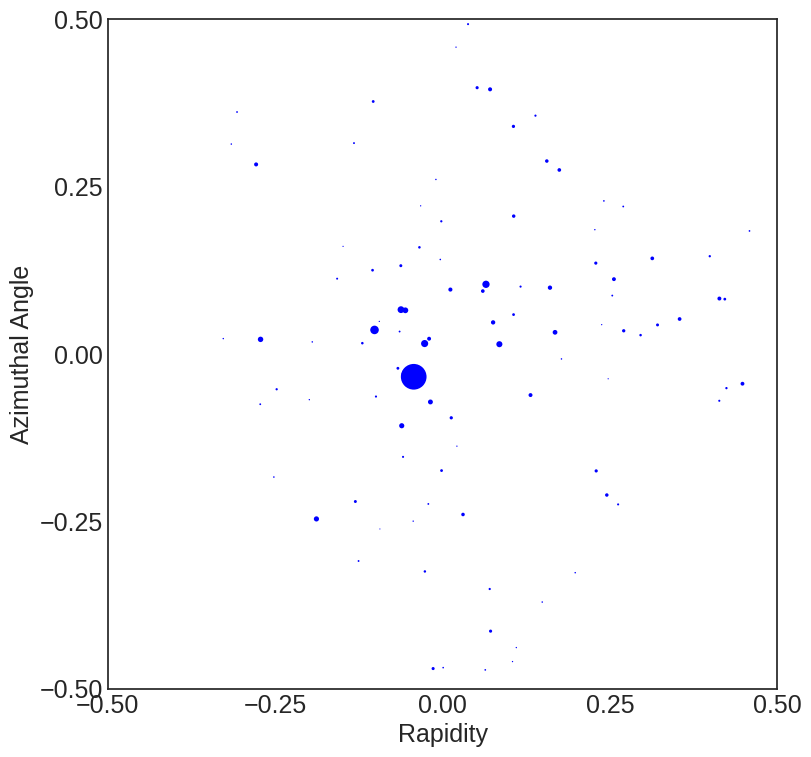

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 500
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# Load data (NOTE: Need the `energyflow` package installed for the default dataset, or provide your own data)
dataset, sim_weights, sim_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)


example_event = dataset[0]
plot_event(example_event[0], example_event[1], R, color = "blue")

In [3]:
import numpy as np

def reconstruct_points(pairwise_distances):
    num_points = int(np.sqrt(2 * len(pairwise_distances)))

    def objective_function(coordinates):
        distances = np.linalg.norm(coordinates - coordinates[:, np.newaxis], axis=2)
        difference = distances[np.triu_indices(num_points, 1)] - pairwise_distances
        return np.sum(difference ** 2)

    initial_guess = np.random.rand(num_points, 2)
    
    result = minimize(objective_function, initial_guess, method='L-BFGS-B')
    optimal_coordinates = result.x.reshape((num_points, 2))
    
    return optimal_coordinates



def calculate_num_particles(s, n_max = 150):

    l = s.shape[0]
    for n in range(n_max):
        num_peaks = 1 + n*(n-1) / 2
        if l == num_peaks:
            return n
        
    return 0

def calculate_energy_triplet(omega12, omega23, omega31):

    e1 = np.sqrt(omega12 * omega31 / 2 / omega23)
    e2 = np.sqrt(omega12 * omega23 / 2 / omega31)
    e3 = np.sqrt(omega23 * omega31 / 2 / omega12)

    return e1, e2, e3

def reconstruct_spectrum(s):

    # Check if event is nondegenerate
    num_particles = calculate_num_particles(s)
    if num_particles == 0:
        raise ValueError("Degenerate event")



    

    points = np.zeros((num_particles, 2))
    zs = np.zeros((num_particles,))
    total_energy = np.sqrt(np.sum(s[:,1]))

    # longest distance
    longest_distance = s[-1,0]
    points[0,:] = np.array((0,0))
    points[1,:] = np.array((longest_distance,0))

    if num_particles == 2:

        t1 = np.sqrt(np.abs(s[0,1] + s[-1,1]))
        t2 = np.sqrt(np.abs(s[0,1] - s[-1,1]))

        e1 = (t1 + t2) / 2
        e2 = (t1 - t2) / 2

        zs[0] = e1
        zs[1] = e2


    elif num_particles >= 3:

        if num_particles == 3:
            second_longest_distance = s[-2,0]
            
        

    return (points, zs)




In [40]:
import numpy as np
from sklearn.manifold import MDS
from scipy.optimize import minimize

def calculate_num_particles(s, n_max = 150):

    l = s.shape[0]
    for n in range(n_max):
        num_peaks = 1 + n*(n-1) / 2
        if l == num_peaks:
            return n
        
    return 0



def standard_orientation(event):
    points, zs = event

    yphi_average = np.average(points, weights=zs, axis = 0)
    points -= yphi_average

    return(points, zs)


def reconstruct_points(s, num_dimensions=2):


    # Check if event is nondegenerate
    num_particles = calculate_num_particles(s)
    if num_particles == 0:
        raise ValueError("Degenerate event")
    
    
    pairwise_distances = s[1:,0]
    pairwise_energies = s[1:,1]
    total_energy = np.sqrt(np.sum(s[:,1]))

    def objective_function(flat_coordinates):
        coordinates = flat_coordinates.reshape((num_particles, 2))
        distances = np.linalg.norm(coordinates - coordinates[:, np.newaxis], axis=2)
        difference = distances[np.triu_indices(num_particles, 1)] - pairwise_distances
        print(np.sum(difference **2))
        return np.sum(difference ** 2)

    initial_guess = (np.random.rand(num_particles *  2) *2 -1) * 0.5
    result = minimize(objective_function, initial_guess, method='L-BFGS-B')
    optimal_coordinates = result.x.reshape((num_particles, 2))



    def energy_objective_function(energies):
        pairwise = energies[:,None] * energies[None,:] * 2
        difference = pairwise[np.triu_indices(num_particles, 1)] - pairwise_energies
        print(np.sum(difference **2))
        return np.sum(difference ** 2)

    initial_guess = np.random.rand(num_particles) * 2 / num_particles
    result = minimize(energy_objective_function, initial_guess, method='L-BFGS-B')
    energies = result.x

    # # Cheat to reconstruct energies by just recalculating the spectrum
    # A = np.zeros((int(num_particles*(num_particles-1)/2), num_particles))
    # b = np.log(pairwise_energies) - np.log(2)

    # m, n = np.triu_indices(num_particles, 1)
    # for i in range(int(num_particles*(num_particles-1)/2)):
    #     A[i,m[i]] = 1
    #     A[i,n[i]] = 1

    # zs = np.linalg.lstsq(A, b)

    return standard_orientation((optimal_coordinates, energies))

print(np.triu_indices(10, 1))





(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7,
       8]), array([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7,
       8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9,
       9]))


553.0556207835168
553.0556199944821
553.055620851299
553.0556215849298
553.0556200980648
553.0556202137058
553.0556203852396
553.0556213040401
553.055621109148
553.0556200569605
553.0556199426771
553.0556207928465
553.0556211388966
553.0556205226558
553.0556207474455
553.0556214521273
553.0556213666679
553.0556207354807
553.0556200240255
553.0556208115308
553.0556207978965
553.0556205785073
553.0556205929378
553.0556205403749
553.0556211578213
553.0556213078031
553.0556211730927
553.0556206912755
553.0556207687715
553.0556201270423
553.05562030615
553.0556206179614
553.0556205758028
553.0556211290996
553.0556205653364
553.0556206507708
553.0556209316701
553.0556203964414
553.0556207664729
553.0556211733707
553.0556202193081
553.0556204779435
553.0556207257798
553.0556212135284
553.0556210781251
553.0556211279815
553.0556213051533
553.0556206752772
553.0556208152923
553.055620494736
553.0556205376004
553.0556208073008
553.055620387929
553.0556205575735
553.055620793668
553.0556210333565

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


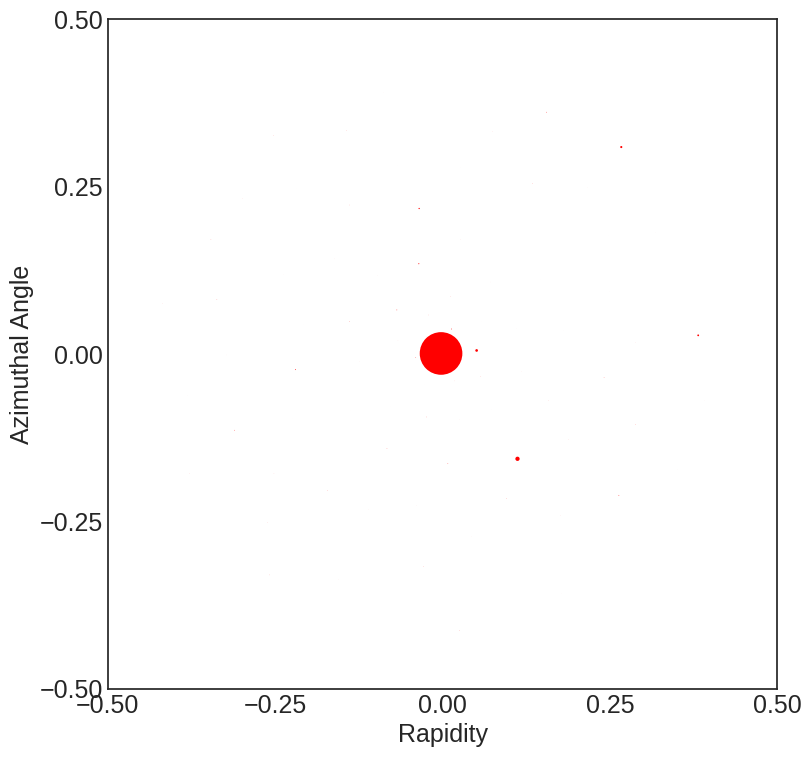

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [42]:
two_particle_event = (np.array(((0,0), (1.0, 0), (0, 0.5))), np.array((0.8, 0.11, 0.09)))
two_particle_spectral = compute_spectral_representation(example_event, type = "jet")

reconstructed = reconstruct_points(two_particle_spectral)
print(reconstructed[1].sum())

plot_event(reconstructed[0], reconstructed[1], R = 0.5, color = "red")